In [1]:
#bounding box with switch
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from IPython.core.display import Image
import time
import imutils#pip install imutils, used only for edged graph

In [2]:
#Set up
#boundaries for red, orange, blue and black
redH = [160,179]    #Red Hue Value Range
orangeH = [0,17]    #Orange Hue Value Range
blueH = [75,130]    #Blue Hue Value Range

S = [90,255]    #Saturation Factor (doesn't really matter)

V = [240,255]   #Value for light emitting devices

BlackV = [0,10] #Black value (darkness)

lowerredBound =  np.array([redH[0],S[0],V[0]])  #Setting up lower bounds for Red
upperredBound = np.array([redH[1],S[1],V[1]])   #Setting up higher bounds for Red

lowerorangeBound =  np.array([orangeH[0],S[0],V[0]])    #Setting up lower bounds for Orange (In effect Red)
upperorangeBound = np.array([orangeH[1],S[1],V[1]])     #Setting up higher bounds for Orange

lowerblueBound = np.array([blueH[0],S[0],V[0]])     #Setting up lower bounds for Blue
upperblueBound = np.array([blueH[1],S[1],V[1]])     #Setting up higher bounds for Blue

lowerblackBound = np.array([0,0,BlackV[0]])         #Setting up lower bounds for Black
upperblackBound = np.array([255,180,BlackV[1]])     #Setting up higher bounds for Black


In [3]:
#light bar detection functions
#Blur factor 3,5,7
Gaussianfactor = 5
#Masks the HSV frame using color bounds
def maskHSV (hsvframe, lowerBound, upperBound, Gaussianfactor): 
    if lowerBound[0] > upperBound[0]:
        midBound1 = np.array([179,upperBound[1],upperBound[2]])
        midBound2 = np.array([0,lowerBound[1],lowerBound[2]])
        mask = cv2.inRange(hsvframe, lowerBound, midBound1)
        mask += cv2.inRange(hsvframe, midBound2, upperBound)
    else:
        mask = cv2.inRange(hsvframe, lowerBound, upperBound)
    mask = cv2.GaussianBlur(mask, (Gaussianfactor,Gaussianfactor), 0)
    return mask
#Find the minAreaRects according to the contour
def findRects (conts):  
    rects = []
    for cont in conts:
        rect = cv2.minAreaRect(cont)
        rects.append(rect)
    return rects
#Filter the rects according to the characteristics of armor
def firstfilterRects (rects):    
    newrects = []
    for rect in rects:
        point, size, ang = rect
        w, h = size
        #if h < w:
            #h,w = w,h
        if (h / w > 1.44 and h / w < 2.2):#还需要精妙的调一调参
            if(ang != -90.0 and ang != 0.0):
                newrects.append(rect)
    for new in newrects:
        print(new)
        print('mustRect')
    return newrects

def filterRects (rects):#Filter the rects according to the characteristics of armor
    mustRects = firstfilterRects(rects)
    if(len(mustRects) != 0):
        print(mustRects[0][1])
        print("mustRectSize")
        musth, mustw = mustRects[0][1]
        mustArea = musth * mustw
        newrects = []
        for rect in rects:
            point, size, ang = rect
            w, h = size
            if(h < w and abs(ang) > 30):
                h,w = w,h
            if (h / w > 1.15 and h / w < 2.3):
                if(h*w < mustArea*2.3 and h*w > mustArea * 0.4):
                    if(abs(ang)!=90.0):
                        newrects.append(rect)
        for new in newrects:
            print(new)
        return newrects
    else:
        newrects = []
    for rect in rects:
        point, size, ang = rect
        h, w = size
        if (h / w > 1.5 and (abs(ang) > 60)) or ((w/h > 1.5) and (abs(ang)<30)):
            newrects.append(rect)
    for new in newrects:
            print(new)
    return newrects
        

def resizeRects (rects, factor):    #Resize the rects back to normal size
    if factor == 1:
        return rects
    newrects = []
    for rect in rects:
        point, size, ang = rect
        h, w = size
        x, y = point
        h /= factor
        w /= factor
        x /= factor
        y /= factor
        rect = ((x, y), (h, w), ang)
        newrects.append(rect)
    return newrects

def drawRects (frame, rects, color):    #Draw the rects on the frame
    for rect in rects:
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(frame, [box], 0, color, 2)
def drawOneRect (frame, rect, color):    #Draw the rects on the frame
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(frame, [box], 0, color, 2)

def recttransform (size, ang):  #make all the rects in desired format
    newang = ang
    h,w = size
    if ang < -60:
        newang = -90 - ang
        return w,h,newang
    elif ang > 60:
        newang = 90 - ang
        return w,h,newang
    return h,w,ang



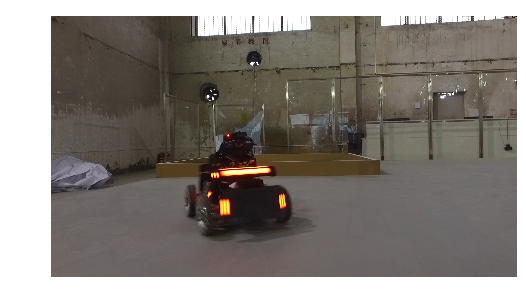

((716.0416870117188, 792.3118286132812), (44.87705612182617, 65.41337585449219), -4.23639440536499)
mustRect
((952.6524658203125, 766.3720092773438), (28.601768493652344, 60.07475280761719), -6.340191841125488)
mustRect
(44.87705612182617, 65.41337585449219)
mustRectSize
((716.0416870117188, 792.3118286132812), (44.87705612182617, 65.41337585449219), -4.23639440536499)
((952.6524658203125, 766.3720092773438), (28.601768493652344, 60.07475280761719), -6.340191841125488)


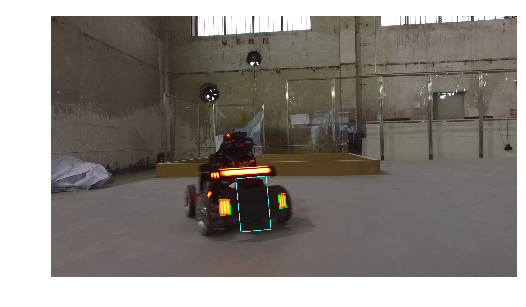

In [4]:
frame = cv2.imread('frame_302.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)    #Convert RGB to HSV for value check

maskred = maskHSV(hsv, lowerredBound, upperorangeBound, Gaussianfactor)
#maskblue = maskHSV(hsv, lowerblueBound, upperblueBound, Gaussianfactor)
#maskblack = maskHSV(hsv, lowerblackBound, upperblackBound)

imred, redconts, hred = cv2.findContours(maskred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #Finding contours of red points
#imblue, blueconts, hblue = cv2.findContours(maskblue.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

redrects = filterRects(findRects(redconts))
boundingBoxes = []

w_offset = 6
h_offset = 2


def avg(a,b):
    return (a+b)/2

for i in range(len(redrects)-1):
    point1,size1,ang1 = redrects[i]
    x1,y1 = point1
    h1,w1 = size1
    point2,size2,ang2 = redrects[i+1]
    x2,y2 = point2
    h2,w2 = size2
    if h1 < w1:
        h1,w1 = w1,h1
    if h2 < w2:
        h2,w2 = w2,h2
    if abs(ang1-ang2) > 8:#if the angle difference of two light bars are big, then use the ang that is closer to 90 or 0
        if(abs(ang1) - 0) > 45 or (abs(ang2) - 0) > 45:
            if (abs(ang1)-90) > (abs(ang2)-90):
                boundingBox = ((avg(x1,x2),avg(y1,y2)),(avg(h1,h2)*h_offset, avg(w1,w2)*w_offset),ang1)
            else:
                boundingBox = ((avg(x1,x2),avg(y1,y2)),(avg(h1,h2)*h_offset, avg(w1,w2)*w_offset),ang2)
        else:
            if (abs(ang1)-0) < (abs(ang2)-0):
                boundingBox = ((avg(x1,x2),avg(y1,y2)),(avg(h1,h2)*w_offset, avg(w1,w2)*h_offset),ang1)
            else:
                boundingBox = ((avg(x1,x2),avg(y1,y2)),(avg(h1,h2)*w_offset, avg(w1,w2)*h_offset),ang2)
            
    else:
        boundingBox = ((avg(x1,x2),avg(y1,y2)),(avg(h1,h2)*h_offset, avg(w1,w2)*w_offset),(ang1+ang2)/2)
    boundingBoxes.append(boundingBox)
    

'''
for redrect in redrects:
    point, size, ang = redrect
    #point, size, ang = redrects[0]
    x,y = point
    h,w = size
    print()
    boundingBox = ((x-x_offset,y-y_offset),(h*h_offset,w*w_offset),ang)
    boundingBoxes.append(boundingBox)
'''
    

#for rect in findRects(redconts):
#Rect(Strip_a.x - x_offset, Strip_a.y - y_offset, (strip_b.x - strip_a.x) + 2 * x_offset)
#drawOneRect(frame, findRects(redconts)[3], (0, 255, 0))
#print(findRects(redconts)[3])
#drawOneRect(frame, redrects[0], (0, 255, 0))
#print(redrects[0])
drawRects(frame, redrects, (0, 255, 0))
drawRects(frame, boundingBoxes, (255, 255, 100))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



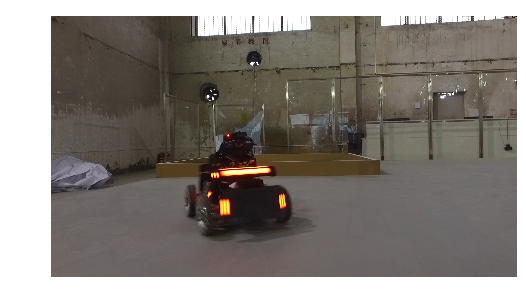

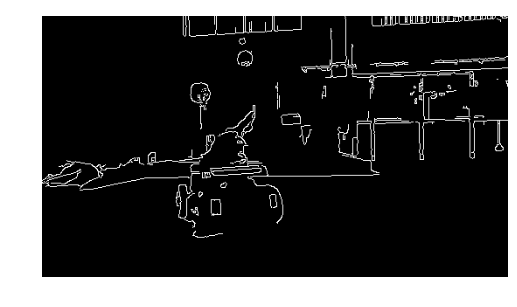

In [5]:
image = cv2.imread('frame_302.jpg')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = 300)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB))
plt.axis('off')
plt.show()

In [6]:
a,b = 60.07474899291992, 26.910123825073242
if b < a:
    b,a = a,b

In [7]:
b/a

2.232421871539137

In [8]:
c,d =53.8134765625, 64.94157409667969

In [9]:
c/d

0.8286444748380585

In [10]:
c*d/(a*b)

2.1617536462914915

In [11]:
53*64

3392

In [12]:
2860/3392

0.8431603773584906

In [13]:
31*50

1550

In [14]:
2860/1550

1.8451612903225807